[Git](https://github.com/Daniil-Selikhanovych/bnn-vi)

[On the Expressiveness of Approximate Inference in Bayesian Neural Networks](https://arxiv.org/pdf/1909.00719.pdf)

[Sufficient Conditions for Idealised Models to Have No
Adversarial Examples: a Theoretical and Empirical
Study with Bayesian Neural Networks](https://arxiv.org/pdf/1806.00667.pdf)

[Variational Inference: A Review for Statisticians](https://arxiv.org/pdf/1601.00670.pdf)

[Neural Networks as Gaussian Process](https://arxiv.org/pdf/1711.00165.pdf)

[VAE in Pyro](https://pyro.ai/examples/svi_part_i.html)

[Neural Networks in Pyro](http://docs.pyro.ai/en/stable/nn.html)

[Bayessian Regression in Pyro](https://pyro.ai/examples/bayesian_regression_ii.html?highlight=sample)

[Intro to HMC](https://arxiv.org/pdf/1206.1901.pdf)

[Stochastic HMC](https://arxiv.org/pdf/1402.4102.pdf)

![details1](../img/description1.png)
![details2](../img/description2.png)

In [1]:
import os, sys
import random
import copy
from itertools import islice
from functools import partial
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset

import pyro
from pyro.infer import (SVI, Trace_ELBO, TraceMeanField_ELBO,
                        MCMC, NUTS
                       )
from pyro.infer.autoguide import (AutoNormal, AutoDiagonalNormal, 
                                  AutoMultivariateNormal
                                 )
from pyro.optim import Adam

In [2]:
rcParams.update({'font.size': 12})

In [3]:
if '..' not in sys.path:
    sys.path.append('..')

In [4]:
%load_ext autoreload
%autoreload 1

%aimport bnn_vi.data_sampling, bnn_vi.models, bnn_vi.utils
from bnn_vi.data_sampling import (CircleDataset,
                                  get_rotation
)
from bnn_vi.models import (Multilayer,
                           MultilayerBayesian,
                           ModelGenerator
)
from bnn_vi.utils import (ProgressPlotter,
                          plot_1D,
                          plot_2D
                         )

torch.manual_seed(42);

In [5]:
if torch.cuda.is_available():
    print("Using CUDA!")
    DEVICE = torch.device('cuda')
    IS_CUDA = True
else:
    print("Using CPU!")
    DEVICE = torch.device('cpu')
    IS_CUDA = False

Using CUDA!


In [6]:
DEVICE = torch.device('cpu')
IS_CUDA = False

In [7]:
BATCH_SIZE = 100
N_WORKERS = 0 if os.name != 'nt' else 0# no threads for windows :c

In [8]:
circles = CircleDataset(BATCH_SIZE, 2, sigma=0.12, target_label=2., include_zero=False)
circles.data @= get_rotation(-45)

In [9]:
gauss_loader = DataLoader(circles, batch_size=BATCH_SIZE, pin_memory=IS_CUDA,
                          shuffle=True, num_workers=N_WORKERS)

In [33]:
pyro.set_rng_seed(1)

N_EPOCHS = 1000
log_per = 5

params = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 50,
    'n_layers': 1,
    'dropout': None,
    'device': DEVICE
}

model = Multilayer(**params)
model_b = MultilayerBayesian(**params)
gen = ModelGenerator(Multilayer, **params)

guide = AutoDiagonalNormal(model_b, init_scale=1e-5)
svi = SVI(model_b, guide, Adam({"lr": 1e-3}), TraceMeanField_ELBO(num_particles=32))

losses = []
pp = ProgressPlotter(losses, log_per)

In [34]:
DO_LOAD = False

In [35]:
samples = None
if DO_LOAD:
    samples = torch.load('samples.pth', map_location='cpu')
else:
    pyro.clear_param_store()
    nuts_kernel = NUTS(model_b)

    mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, num_chains=2)
    mcmc.run(circles.data.float().to(DEVICE), circles.target[:, 0].float().to(DEVICE))
    samples = mcmc.get_samples()
    torch.save(samples, 'samples.pth')

KeyboardInterrupt: 

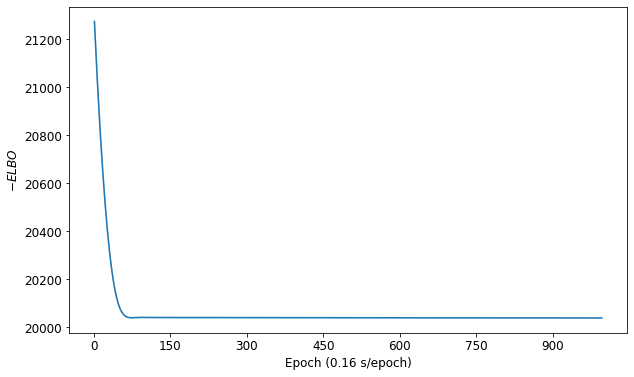

In [55]:
pyro.clear_param_store()

pp.start()
for epoch in range(N_EPOCHS):
    total_loss = 0.
    for i, batch in enumerate(gauss_loader):
        x, y = batch
        x, y = x.float().to(DEVICE), y[:, 0].float().to(DEVICE)
        loss = svi.step(x, y) / y.numel()
        total_loss += loss
    total_loss /= len(gauss_loader)
    losses.append(total_loss)
    
    pp.update(epoch)

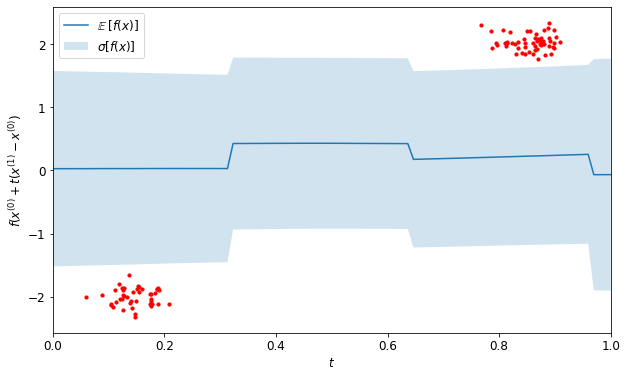

In [13]:
plot_1D(np.array([-1, -1]), np.array([1, 1]), model_b.get_mean_std, num_points=100,
        data=(circles.data, circles.target[:, 0]))

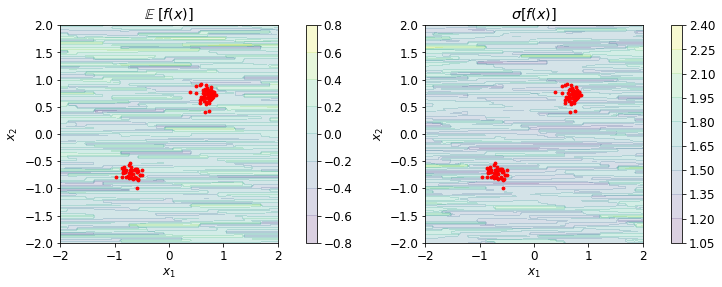

In [17]:
plot_2D((-2, 2), (-2, 2), model_b.get_mean_std, num_points=100,
        data=circles.data)